In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

In [3]:
# input datas
train_dataset.data.shape, test_dataset.data.shape

# output datas
train_dataset.targets.shape, test_dataset.targets.shape

(torch.Size([60000]), torch.Size([10000]))

In [4]:
import matplotlib.pyplot as plt

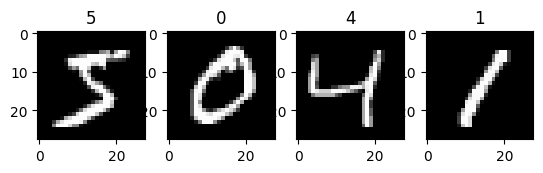

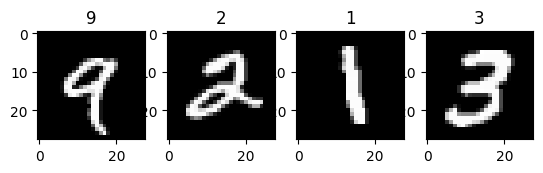

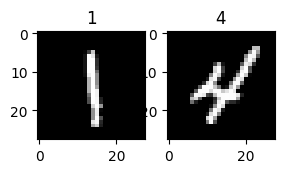

In [5]:
plot_size = 4
for it_sam, _sample in enumerate(train_dataset.data[:10]):

    cur_idx = it_sam%plot_size+1

    plt.subplot(1, plot_size, cur_idx)

    _sample_target = train_dataset.targets[it_sam]
    plt.title(_sample_target.item())
    plt.imshow(_sample, 'gray')


    if cur_idx == plot_size:
        plt.show()

# model init

In [6]:
class Mnist_fcn(nn.Module):
    
    def __init__(self, model_input, model_output):
        super(Mnist_fcn, self).__init__()
        
        #28 x 28 = 784
        # layer
        self.fc = nn.Linear(model_input, 64) # learning weight, bias
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, model_output)
        
        #activation 
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.fc(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        
       # Cross Entropy Loss --> softmax 생략
        
        return out

In [7]:
model = Mnist_fcn(28*28, 10)

In [8]:
print(model)

Mnist_fcn(
  (fc): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [9]:
from torchsummary import summary

summary(model, input_size=((1, 784)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]          50,240
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 32]           2,080
              ReLU-4                [-1, 1, 32]               0
            Linear-5                [-1, 1, 10]             330
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


# model learning 

In [10]:
learning_rate = 1e-2 #0.01

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
device = 'mps'

In [ ]:
epochs = 10

model = model.to(device)

for _epoch in range(epochs):
    for it_batch, (images, labels) in enumerate(train_loader):
        
        images = images.reshape([100, -1])
        images = images.to(device)
        
        # label
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        
        if (it_batch+1) % 100 == 0 :
            print(f'epoch{_epoch}, batch{it_batch}, loss{loss.item()}' )
            
            with torch.no_grad():
                model.eval()

                correct_ = 0
                total_ = 0

                for it_batch, (images, labels) in enumerate(test_loader):
                    images = images.reshape([100, -1])
                    images = images.to(device)
                    
                    labels = labels.to(device)
                    outputs = model(images)
                    pred=torch.argmax(outputs, axis=1)

                    total_ += pred.shape[0]
                    correct_ += (labels==pred).sum()


                acc = correct_/total_ * 100
                print(f'acc:{acc}, correct:{correct_}, total:{total_}')
                
                model.train()
        

epoch0, batch99, loss0.4025234878063202
acc:91.44999694824219, correct:9145, total:10000
epoch0, batch199, loss0.39242666959762573
acc:91.80999755859375, correct:9181, total:10000
epoch0, batch299, loss0.13755224645137787
acc:93.6500015258789, correct:9365, total:10000
epoch0, batch399, loss0.2265511006116867
acc:94.6300048828125, correct:9463, total:10000
epoch0, batch499, loss0.14157061278820038
acc:95.08000183105469, correct:9508, total:10000
epoch0, batch599, loss0.21642793715000153
acc:95.55000305175781, correct:9555, total:10000
epoch1, batch99, loss0.14454974234104156
acc:95.18000030517578, correct:9518, total:10000
epoch1, batch199, loss0.13805335760116577
acc:95.84000396728516, correct:9584, total:10000
epoch1, batch299, loss0.14919382333755493
acc:95.16000366210938, correct:9516, total:10000
epoch1, batch399, loss0.03576848283410072
acc:95.16000366210938, correct:9516, total:10000
epoch1, batch499, loss0.1856726109981537
acc:96.0300064086914, correct:9603, total:10000
epoch1,

# calc Accuracy

In [ ]:
model = model.to('cpu')

In [ ]:
with torch.no_grad():
    model.eval()
    
    correct_ = 0
    total_ = 0

    for it_batch, (images, labels) in enumerate(test_loader):
        images = images.reshape([100, -1])

        outputs = model(images)
        pred=torch.argmax(outputs, axis=1)

        total_ += pred.shape[0]
        correct_ += (labels==pred).sum()
    
    
    acc = correct_/total_ * 100
    print(f'acc{acc}, correct{correct_}, total{total_}')